In [1]:
# Civil War Prediction ML Model using Logistic Regression
# Data Sources: UCDP/PRIO Conflict Data, Polity5, Economic Indicators

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_auc_score, roc_curve, precision_recall_curve,
                              accuracy_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# ========================
# 1. LOAD DATASETS
# ========================

print("Loading datasets...")

# Load UCDP/PRIO Conflict Data
conflict_data = pd.read_csv('datasets/UcdpPrioConflict_v25_1.csv')
print(f"Conflict data shape: {conflict_data.shape}")
print("\nConflict data columns:")
print(conflict_data.columns.tolist())

# Load Polity5 data
polity_data = pd.read_excel('datasets/p5v2018.xls')
print(f"\nPolity5 data shape: {polity_data.shape}")
print("\nPolity5 columns:")
print(polity_data.columns.tolist())

# Display sample data
print("\n" + "="*50)
print("SAMPLE DATA")
print("="*50)
print("\nConflict Data Sample:")
print(conflict_data.head())
print("\nPolity5 Data Sample:")
print(polity_data.head())

Loading datasets...
Conflict data shape: (2752, 28)

Conflict data columns:
['conflict_id', 'location', 'side_a', 'side_a_id', 'side_a_2nd', 'side_b', 'side_b_id', 'side_b_2nd', 'incompatibility', 'territory_name', 'year', 'intensity_level', 'cumulative_intensity', 'type_of_conflict', 'start_date', 'start_prec', 'start_date2', 'start_prec2', 'ep_end', 'ep_end_date', 'ep_end_prec', 'gwno_a', 'gwno_a_2nd', 'gwno_b', 'gwno_b_2nd', 'gwno_loc', 'region', 'version']

Polity5 data shape: (17574, 37)

Polity5 columns:
['p5', 'cyear', 'ccode', 'scode', 'country', 'year', 'flag', 'fragment', 'democ', 'autoc', 'polity', 'polity2', 'durable', 'xrreg', 'xrcomp', 'xropen', 'xconst', 'parreg', 'parcomp', 'exrec', 'exconst', 'polcomp', 'prior', 'emonth', 'eday', 'eyear', 'eprec', 'interim', 'bmonth', 'bday', 'byear', 'bprec', 'post', 'change', 'd5', 'sf', 'regtrans']

SAMPLE DATA

Conflict Data Sample:
   conflict_id       location               side_a side_a_id side_a_2nd  \
0        11342          I

Exploring conflict types...

Type of Conflict Distribution:
type_of_conflict
3    2004
4     484
2     147
1     117
Name: count, dtype: int64

Conflict Type Mapping:
1 = Extrasystemic (state vs. non-state outside territory)
2 = Interstate (state vs. state)
3 = Internal/Civil War (state vs. rebel group)
4 = Internationalized internal (civil war with foreign intervention)

Intensity Level Distribution:
intensity_level
1    2066
2     686
Name: count, dtype: int64
1 = Minor conflict (25-999 battle deaths)
2 = War (1000+ battle deaths)


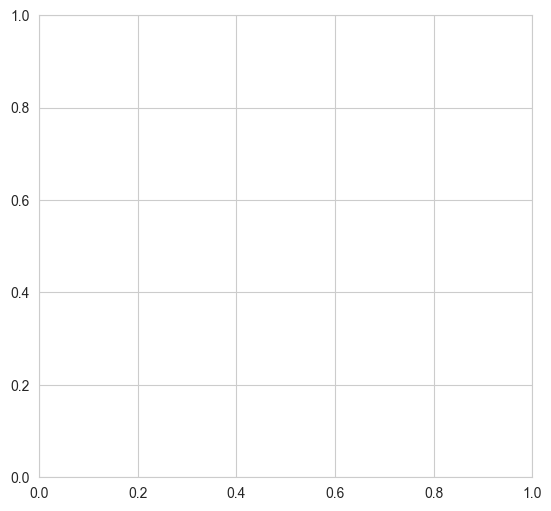

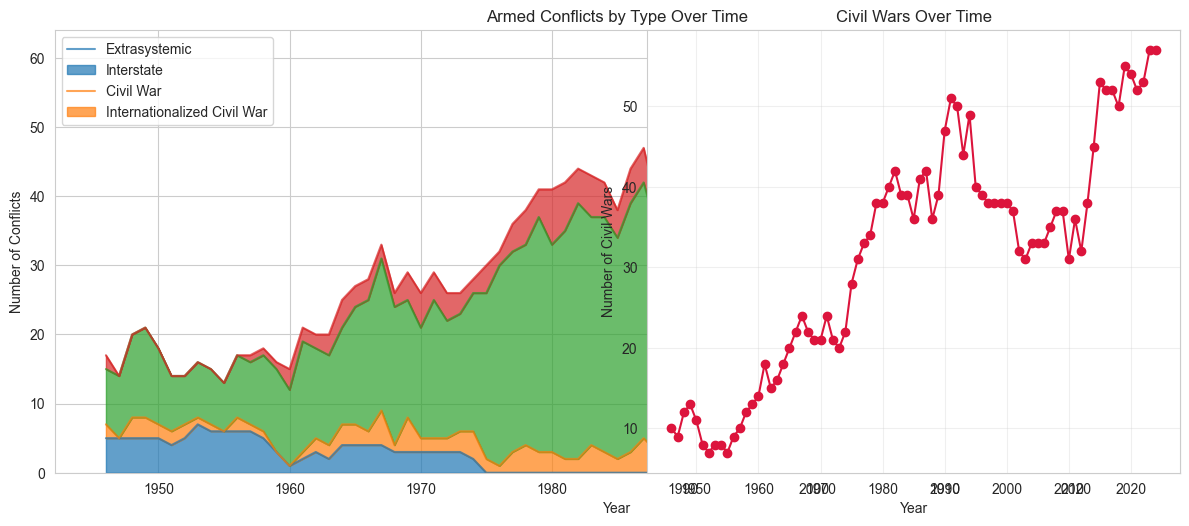


Total civil war records (type 3 & 4): 2488


In [5]:
# ========================
# 2. DATA EXPLORATION
# ========================

print("Exploring conflict types...")
print("\nType of Conflict Distribution:")
print(conflict_data['type_of_conflict'].value_counts())
print("\nConflict Type Mapping:")
print("1 = Extrasystemic (state vs. non-state outside territory)")
print("2 = Interstate (state vs. state)")
print("3 = Internal/Civil War (state vs. rebel group)")
print("4 = Internationalized internal (civil war with foreign intervention)")

# Focus on civil wars (type 3 and 4)
print("\nIntensity Level Distribution:")
print(conflict_data['intensity_level'].value_counts())
print("1 = Minor conflict (25-999 battle deaths)")
print("2 = War (1000+ battle deaths)")

# Visualize conflict types over time
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
conflict_by_year = conflict_data.groupby(['year', 'type_of_conflict']).size().unstack(fill_value=0)
conflict_by_year.plot(kind='area', stacked=True, alpha=0.7)
plt.title('Armed Conflicts by Type Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Conflicts')
plt.legend(['Extrasystemic', 'Interstate', 'Civil War', 'Internationalized Civil War'])

plt.subplot(1, 2, 2)
civil_wars = conflict_data[conflict_data['type_of_conflict'].isin([3, 4])]
civil_war_counts = civil_wars.groupby('year').size()
civil_war_counts.plot(kind='line', marker='o', color='crimson')
plt.title('Civil Wars Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Civil Wars')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal civil war records (type 3 & 4): {len(civil_wars)}")

In [6]:
# ========================
# 3. PREPARE TARGET VARIABLE
# ========================

print("Creating target variable: Civil War Onset...")

# Create a dataset of country-years with civil war onset indicator
# Civil war onset = start of a new civil war (type 3 or 4)

# Extract civil war onsets
civil_wars = conflict_data[conflict_data['type_of_conflict'].isin([3, 4])].copy()

# Create onset indicator (first year of conflict for each conflict_id)
civil_wars['is_onset'] = civil_wars.groupby('conflict_id')['year'].transform(lambda x: x == x.min())
civil_war_onsets = civil_wars[civil_wars['is_onset']][['gwno_loc', 'year']].copy()
civil_war_onsets.columns = ['country_code', 'year']
civil_war_onsets['civil_war_onset'] = 1

# Get unique country-years from conflict data
all_conflict_years = conflict_data[['gwno_loc', 'year']].drop_duplicates()
all_conflict_years.columns = ['country_code', 'year']

print(f"\nCivil war onsets detected: {len(civil_war_onsets)}")
print("\nSample onsets:")
print(civil_war_onsets.head(10))

Creating target variable: Civil War Onset...

Civil war onsets detected: 230

Sample onsets:
   country_code  year  civil_war_onset
0           750  2012                1
6           625  2011                1
7           626  2011                1
18          620  2011                1
25          432  2009                1
40          710  2008                1
41          771  2005                1
43          530  1991                1
44          775  1991                1
51          820  2013                1


In [10]:
# ========================
# 4. MERGE WITH POLITY5 DATA
# ========================

print("Merging with Polity5 political regime data...")

# Check Polity5 column names
print("\nPolity5 key columns:")
polity_cols = [col for col in polity_data.columns if col.lower() in 
               ['country', 'year', 'cyear', 'ccode', 'scode', 'polity', 'polity2', 
                'democ', 'autoc', 'durable', 'xrreg', 'xrcomp', 'xropen', 'xconst', 
                'parreg', 'parcomp', 'exrec', 'exconst', 'polcomp']]
print(polity_cols)

# Prepare Polity5 data
polity_clean = polity_data.copy()

# Check data types
print(f"\nPolity ccode type: {polity_clean['ccode'].dtype}")
print(f"Civil war onsets country_code type: {civil_war_onsets['country_code'].dtype}")

# Convert both to the same type (int) for merging
# First, handle any non-numeric values in civil_war_onsets
civil_war_onsets['country_code'] = pd.to_numeric(civil_war_onsets['country_code'], errors='coerce')
civil_war_onsets = civil_war_onsets.dropna(subset=['country_code'])  # Drop any rows that couldn't be converted
civil_war_onsets['country_code'] = civil_war_onsets['country_code'].astype(int)

print(f"\nAfter conversion - country_code type: {civil_war_onsets['country_code'].dtype}")
print(f"Civil war onsets after cleaning: {len(civil_war_onsets)}")

# Now merge with matching data types
polity_clean = polity_clean.merge(civil_war_onsets, 
                                   left_on=['ccode', 'year'], 
                                   right_on=['country_code', 'year'], 
                                   how='left')

# Fill NaN in civil_war_onset with 0 (no onset)
polity_clean['civil_war_onset'] = polity_clean['civil_war_onset'].fillna(0).astype(int)

print(f"\nMerged dataset shape: {polity_clean.shape}")
print(f"Civil war onsets in dataset: {polity_clean['civil_war_onset'].sum()}")
print(f"Class balance:")
print(polity_clean['civil_war_onset'].value_counts(normalize=True))

Merging with Polity5 political regime data...

Polity5 key columns:
['cyear', 'ccode', 'scode', 'country', 'year', 'democ', 'autoc', 'polity', 'polity2', 'durable', 'xrreg', 'xrcomp', 'xropen', 'xconst', 'parreg', 'parcomp', 'exrec', 'exconst', 'polcomp']

Polity ccode type: int64
Civil war onsets country_code type: object

After conversion - country_code type: int64
Civil war onsets after cleaning: 230

Merged dataset shape: (17589, 39)
Civil war onsets in dataset: 208
Class balance:
civil_war_onset
0    0.988174
1    0.011826
Name: proportion, dtype: float64


In [11]:
# ========================
# 5. FEATURE ENGINEERING
# ========================

print("Engineering features for the model...")

# Key Polity5 features for civil war prediction:
# - polity2: Combined democracy-autocracy score (-10 to +10)
# - democ: Institutionalized democracy (0-10)
# - autoc: Institutionalized autocracy (0-10)
# - durable: Regime durability (years)
# - xconst: Executive constraints
# - polcomp: Political competition
# - Various institutional measures

# Select relevant features
feature_columns = ['polity2', 'democ', 'autoc', 'durable', 'xconst', 
                   'xrcomp', 'xropen', 'parcomp', 'exrec', 'exconst']

# Check which columns exist
available_features = [col for col in feature_columns if col in polity_clean.columns]
print(f"\nAvailable features: {available_features}")

# Create modeling dataset
model_data = polity_clean[['year', 'ccode', 'civil_war_onset'] + available_features].copy()

# Handle special codes in Polity data (typically -66, -77, -88 for various types of missing/special)
for col in available_features:
    # Replace special codes with NaN
    model_data[col] = model_data[col].replace([-66, -77, -88, -99], np.nan)

# Create additional features
if 'polity2' in available_features:
    # Regime instability (autocracy)
    model_data['anocracy'] = ((model_data['polity2'] >= -5) & (model_data['polity2'] <= 5)).astype(int)
    
    # Full autocracy
    model_data['full_autocracy'] = (model_data['polity2'] <= -6).astype(int)
    
    # Political instability (low durability)
    if 'durable' in available_features:
        model_data['new_regime'] = (model_data['durable'] <= 2).astype(int)

# Add lagged features (previous year's values)
model_data = model_data.sort_values(['ccode', 'year'])
for col in available_features:
    model_data[f'{col}_lag1'] = model_data.groupby('ccode')[col].shift(1)

# Add change features (regime change)
if 'polity2' in available_features:
    model_data['polity_change'] = model_data.groupby('ccode')['polity2'].diff()
    model_data['regime_change'] = (abs(model_data['polity_change']) >= 3).astype(int)

print(f"\nModel data shape after feature engineering: {model_data.shape}")
print("\nFeatures created:")
print(model_data.columns.tolist())

# Display feature statistics
print("\n" + "="*50)
print("FEATURE STATISTICS")
print("="*50)
print(model_data.describe())

Engineering features for the model...

Available features: ['polity2', 'democ', 'autoc', 'durable', 'xconst', 'xrcomp', 'xropen', 'parcomp', 'exrec', 'exconst']

Model data shape after feature engineering: (17589, 28)

Features created:
['year', 'ccode', 'civil_war_onset', 'polity2', 'democ', 'autoc', 'durable', 'xconst', 'xrcomp', 'xropen', 'parcomp', 'exrec', 'exconst', 'anocracy', 'full_autocracy', 'new_regime', 'polity2_lag1', 'democ_lag1', 'autoc_lag1', 'durable_lag1', 'xconst_lag1', 'xrcomp_lag1', 'xropen_lag1', 'parcomp_lag1', 'exrec_lag1', 'exconst_lag1', 'polity_change', 'regime_change']

FEATURE STATISTICS
               year         ccode  civil_war_onset       polity2  \
count  17589.000000  17589.000000     17589.000000  17322.000000   
mean    1940.945591    404.083575         0.011826     -0.523496   
std       60.245461    249.496052         0.108104      7.007040   
min     1776.000000      2.000000         0.000000    -10.000000   
25%     1894.000000    200.000000   

In [12]:
# ========================
# 6. PREPARE DATA FOR MODELING
# ========================

print("Preparing data for modeling...")

# Drop rows with missing values in key features
model_data_clean = model_data.dropna()
print(f"Data shape after removing NaN: {model_data_clean.shape}")
print(f"Civil war onsets remaining: {model_data_clean['civil_war_onset'].sum()}")

# Separate features and target
X = model_data_clean.drop(['year', 'ccode', 'civil_war_onset'], axis=1)
y = model_data_clean['civil_war_onset']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts(normalize=True)}")

# Feature names
feature_names = X.columns.tolist()
print(f"\nFinal feature set ({len(feature_names)} features):")
for i, feat in enumerate(feature_names, 1):
    print(f"{i}. {feat}")

Preparing data for modeling...
Data shape after removing NaN: (14954, 28)
Civil war onsets remaining: 172

Features (X) shape: (14954, 25)
Target (y) shape: (14954,)

Class distribution:
civil_war_onset
0    14782
1      172
Name: count, dtype: int64

Class balance: civil_war_onset
0    0.988498
1    0.011502
Name: proportion, dtype: float64

Final feature set (25 features):
1. polity2
2. democ
3. autoc
4. durable
5. xconst
6. xrcomp
7. xropen
8. parcomp
9. exrec
10. exconst
11. anocracy
12. full_autocracy
13. new_regime
14. polity2_lag1
15. democ_lag1
16. autoc_lag1
17. durable_lag1
18. xconst_lag1
19. xrcomp_lag1
20. xropen_lag1
21. parcomp_lag1
22. exrec_lag1
23. exconst_lag1
24. polity_change
25. regime_change


In [13]:
# ========================
# 7. SPLIT DATA
# ========================

print("Splitting data into train and test sets...")

# Use stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} ({y_train.sum()} onsets)")
print(f"Test set size: {X_test.shape[0]} ({y_test.sum()} onsets)")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures standardized.")

Splitting data into train and test sets...
Training set size: 11963 (138 onsets)
Test set size: 2991 (34 onsets)

Features standardized.


Building Logistic Regression model...
✓ Model trained successfully!

FEATURE IMPORTANCE (Logistic Regression Coefficients)
           Feature  Coefficient  Abs_Coefficient
8            exrec     1.573210         1.573210
5           xrcomp    -1.142869         1.142869
9          exconst     0.958718         0.958718
18     xrcomp_lag1     0.918490         0.918490
1            democ    -0.882168         0.882168
17     xconst_lag1    -0.769752         0.769752
22    exconst_lag1     0.681396         0.681396
14      democ_lag1    -0.529821         0.529821
16    durable_lag1    -0.490838         0.490838
4           xconst    -0.490555         0.490555
3          durable     0.393480         0.393480
12      new_regime     0.384623         0.384623
2            autoc    -0.340877         0.340877
19     xropen_lag1     0.336999         0.336999
21      exrec_lag1    -0.331971         0.331971
20    parcomp_lag1    -0.299504         0.299504
0          polity2    -0.292410         0.29

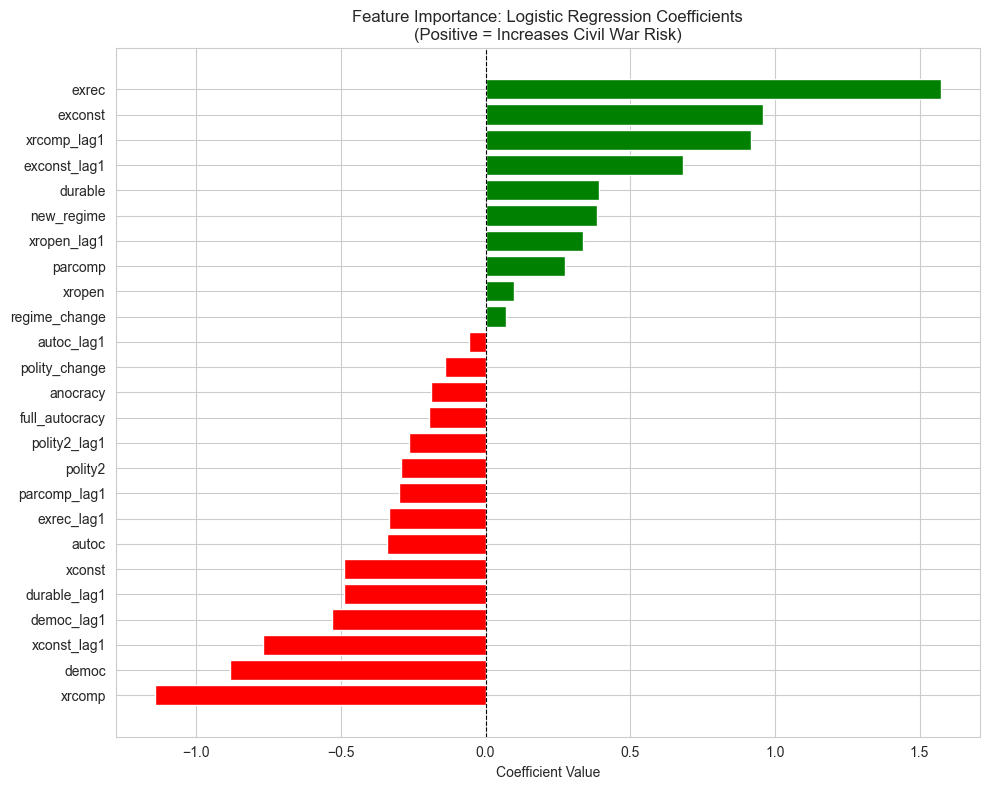

In [14]:
# ========================
# 8. BUILD LOGISTIC REGRESSION MODEL
# ========================

print("Building Logistic Regression model...")

# Since we have imbalanced classes, we'll use class_weight='balanced'
# This gives more weight to the minority class (civil war onsets)

# Basic logistic regression
lr_model = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,
    random_state=42
)

# Fit the model
lr_model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully!")

# Display feature importance (coefficients)
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*50)
print("FEATURE IMPORTANCE (Logistic Regression Coefficients)")
print("="*50)
print(coefficients)

# Visualize feature importance
plt.figure(figsize=(10, 8))
coefficients_sorted = coefficients.sort_values('Coefficient')
colors = ['red' if x < 0 else 'green' for x in coefficients_sorted['Coefficient']]
plt.barh(coefficients_sorted['Feature'], coefficients_sorted['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance: Logistic Regression Coefficients\n(Positive = Increases Civil War Risk)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

Evaluating model performance...

MODEL PERFORMANCE

TRAINING SET:
Accuracy: 0.7053
ROC-AUC: 0.7542
F1-Score: 0.0496

TEST SET:
Accuracy: 0.7131
ROC-AUC: 0.7036
F1-Score: 0.0403

CLASSIFICATION REPORT (Test Set):
                 precision    recall  f1-score   support

       No Onset       0.99      0.72      0.83      2957
Civil War Onset       0.02      0.53      0.04        34

       accuracy                           0.71      2991
      macro avg       0.51      0.62      0.44      2991
   weighted avg       0.98      0.71      0.82      2991


CONFUSION MATRIX (Test Set):
[[2115  842]
 [  16   18]]


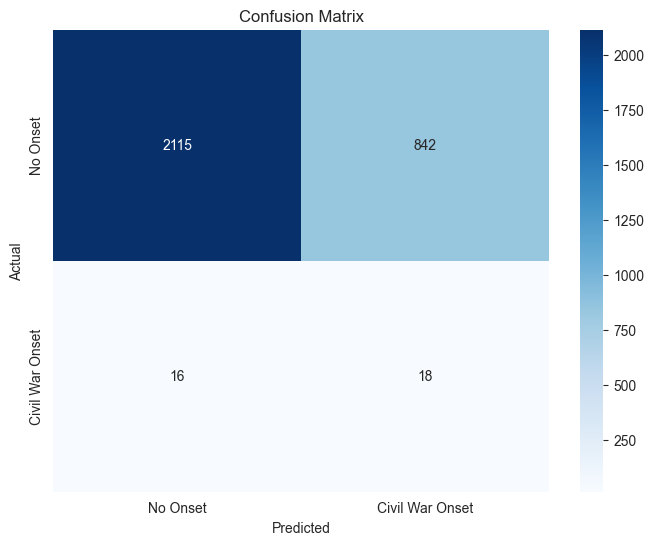

In [15]:
# ========================
# 9. MODEL EVALUATION
# ========================

print("Evaluating model performance...")

# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

y_train_pred_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("\n" + "="*50)
print("MODEL PERFORMANCE")
print("="*50)

print("\nTRAINING SET:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")

print("\nTEST SET:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")

print("\nCLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Onset', 'Civil War Onset']))

# Confusion Matrix
print("\nCONFUSION MATRIX (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Onset', 'Civil War Onset'],
            yticklabels=['No Onset', 'Civil War Onset'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Plotting ROC and Precision-Recall curves...


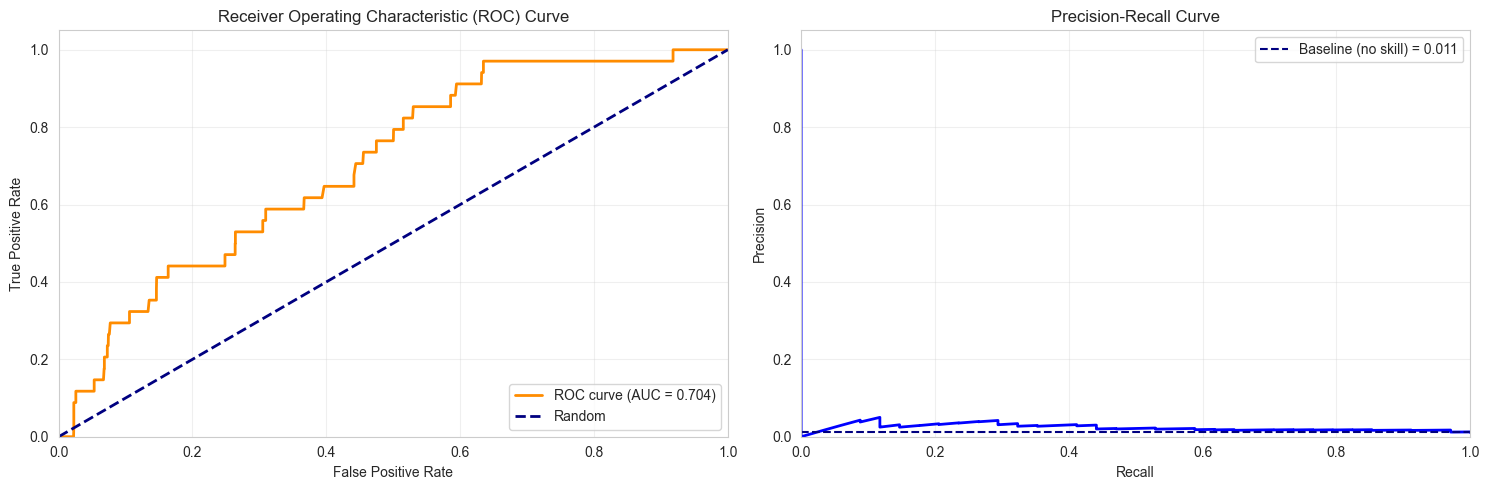

In [16]:
# ========================
# 10. ROC CURVE AND PRECISION-RECALL
# ========================

print("Plotting ROC and Precision-Recall curves...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall, precision, color='blue', lw=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].grid(alpha=0.3)

# Add baseline (random classifier)
baseline = y_test.sum() / len(y_test)
axes[1].axhline(y=baseline, color='navy', linestyle='--', 
                label=f'Baseline (no skill) = {baseline:.3f}')
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [17]:
# ========================
# 11. CROSS-VALIDATION
# ========================

print("Performing cross-validation...")

cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, 
                             cv=5, scoring='roc_auc')

print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("="*50)
print(f"ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f}")
print(f"Std ROC-AUC: {cv_scores.std():.4f}")

Performing cross-validation...

CROSS-VALIDATION RESULTS (5-Fold)
ROC-AUC Scores: [0.66945787 0.79204923 0.74197372 0.65047373 0.70054812]
Mean ROC-AUC: 0.7109
Std ROC-AUC: 0.0510


In [18]:
# ========================
# 12. HYPERPARAMETER TUNING (OPTIONAL)
# ========================

print("Tuning hyperparameters with GridSearchCV...")

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both L1 and L2
}

grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*50)
print("BEST HYPERPARAMETERS")
print("="*50)
print(grid_search.best_params_)
print(f"Best Cross-Validation ROC-AUC: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test_scaled)
y_test_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nBEST MODEL TEST SET PERFORMANCE:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_best):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_best):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_best):.4f}")

print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_test_pred_best, 
                           target_names=['No Onset', 'Civil War Onset']))

Tuning hyperparameters with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

BEST HYPERPARAMETERS
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation ROC-AUC: 0.7193

BEST MODEL TEST SET PERFORMANCE:
Accuracy: 0.7182
ROC-AUC: 0.7041
F1-Score: 0.0366

Classification Report (Best Model):
                 precision    recall  f1-score   support

       No Onset       0.99      0.72      0.83      2957
Civil War Onset       0.02      0.47      0.04        34

       accuracy                           0.72      2991
      macro avg       0.51      0.60      0.44      2991
   weighted avg       0.98      0.72      0.83      2991



In [19]:
# ========================
# 13. SUMMARY AND KEY FINDINGS
# ========================

print("\n" + "="*70)
print("CIVIL WAR PREDICTION MODEL - SUMMARY")
print("="*70)

print("\n📊 DATA SUMMARY:")
print(f"   • Total observations: {len(model_data_clean)}")
print(f"   • Civil war onsets: {y.sum()}")
print(f"   • Features used: {len(feature_names)}")
print(f"   • Time period: {model_data_clean['year'].min()} - {model_data_clean['year'].max()}")

print("\n🎯 MODEL PERFORMANCE:")
print(f"   • Test ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"   • Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"   • Test F1-Score: {f1_score(y_test, y_test_pred):.4f}")

print("\n🔑 TOP RISK FACTORS (by coefficient magnitude):")
top_features = coefficients.head(5)
for idx, row in top_features.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"   • {row['Feature']}: {direction} civil war risk (coef: {row['Coefficient']:.4f})")

print("\n💡 KEY INSIGHTS:")
print("   • Logistic regression provides interpretable coefficients")
print("   • Class imbalance addressed with balanced class weights")
print("   • Consider ensemble methods for improved performance")
print("   • Economic indicators could further enhance predictions")

print("\n" + "="*70)


CIVIL WAR PREDICTION MODEL - SUMMARY

📊 DATA SUMMARY:
   • Total observations: 14954
   • Civil war onsets: 172
   • Features used: 25
   • Time period: 1790 - 2018

🎯 MODEL PERFORMANCE:
   • Test ROC-AUC: 0.7036
   • Test Accuracy: 0.7131
   • Test F1-Score: 0.0403

🔑 TOP RISK FACTORS (by coefficient magnitude):
   • exrec: increases civil war risk (coef: 1.5732)
   • xrcomp: decreases civil war risk (coef: -1.1429)
   • exconst: increases civil war risk (coef: 0.9587)
   • xrcomp_lag1: increases civil war risk (coef: 0.9185)
   • democ: decreases civil war risk (coef: -0.8822)

💡 KEY INSIGHTS:
   • Logistic regression provides interpretable coefficients
   • Class imbalance addressed with balanced class weights
   • Consider ensemble methods for improved performance
   • Economic indicators could further enhance predictions



RUN 2

In [20]:
# ========================
# IMPROVED FEATURE ENGINEERING
# ========================

print("Creating advanced features for better prediction...")

# Recreate the model_data from polity_clean
feature_columns = ['polity2', 'democ', 'autoc', 'durable', 'xconst', 
                   'xrcomp', 'xropen', 'parcomp', 'exrec', 'exconst']

available_features = [col for col in feature_columns if col in polity_clean.columns]

# Create enhanced modeling dataset
model_data_enhanced = polity_clean[['year', 'ccode', 'civil_war_onset'] + available_features].copy()

# Handle special codes in Polity data
for col in available_features:
    model_data_enhanced[col] = model_data_enhanced[col].replace([-66, -77, -88, -99], np.nan)

# Sort for time-series features
model_data_enhanced = model_data_enhanced.sort_values(['ccode', 'year'])

# ==================
# ADVANCED FEATURES
# ==================

# 1. Regime Type Features
if 'polity2' in available_features:
    model_data_enhanced['anocracy'] = ((model_data_enhanced['polity2'] >= -5) & 
                                       (model_data_enhanced['polity2'] <= 5)).astype(int)
    model_data_enhanced['full_autocracy'] = (model_data_enhanced['polity2'] <= -6).astype(int)
    model_data_enhanced['full_democracy'] = (model_data_enhanced['polity2'] >= 6).astype(int)
    model_data_enhanced['polity_squared'] = model_data_enhanced['polity2'] ** 2  # Non-linear effects

# 2. Regime Stability Features
if 'durable' in available_features:
    model_data_enhanced['new_regime'] = (model_data_enhanced['durable'] <= 2).astype(int)
    model_data_enhanced['very_new_regime'] = (model_data_enhanced['durable'] <= 1).astype(int)
    model_data_enhanced['unstable_regime'] = (model_data_enhanced['durable'] <= 5).astype(int)
    model_data_enhanced['log_durable'] = np.log1p(model_data_enhanced['durable'])  # Log transform

# 3. Lagged Features (1, 2, and 3 years)
for col in available_features:
    model_data_enhanced[f'{col}_lag1'] = model_data_enhanced.groupby('ccode')[col].shift(1)
    model_data_enhanced[f'{col}_lag2'] = model_data_enhanced.groupby('ccode')[col].shift(2)
    model_data_enhanced[f'{col}_lag3'] = model_data_enhanced.groupby('ccode')[col].shift(3)

# 4. Change Features (regime transitions are critical!)
if 'polity2' in available_features:
    model_data_enhanced['polity_change_1yr'] = model_data_enhanced.groupby('ccode')['polity2'].diff()
    model_data_enhanced['polity_change_2yr'] = model_data_enhanced.groupby('ccode')['polity2'].diff(2)
    
    # Major regime change indicators
    model_data_enhanced['major_regime_change'] = (abs(model_data_enhanced['polity_change_1yr']) >= 3).astype(int)
    model_data_enhanced['massive_regime_change'] = (abs(model_data_enhanced['polity_change_1yr']) >= 5).astype(int)
    
    # Direction of change
    model_data_enhanced['democratization'] = (model_data_enhanced['polity_change_1yr'] > 0).astype(int)
    model_data_enhanced['autocratization'] = (model_data_enhanced['polity_change_1yr'] < 0).astype(int)

# 5. Executive Constraints Changes
if 'xconst' in available_features:
    model_data_enhanced['xconst_change'] = model_data_enhanced.groupby('ccode')['xconst'].diff()
    model_data_enhanced['xconst_decline'] = (model_data_enhanced['xconst_change'] < 0).astype(int)

# 6. Competition Features
if 'parcomp' in available_features and 'xrcomp' in available_features:
    model_data_enhanced['low_competition'] = ((model_data_enhanced['parcomp'] <= 2) | 
                                               (model_data_enhanced['xrcomp'] <= 2)).astype(int)

# 7. Volatility Features (rolling standard deviation)
if 'polity2' in available_features:
    model_data_enhanced['polity_volatility_3yr'] = (model_data_enhanced.groupby('ccode')['polity2']
                                                    .transform(lambda x: x.rolling(3, min_periods=1).std()))
    model_data_enhanced['polity_volatility_5yr'] = (model_data_enhanced.groupby('ccode')['polity2']
                                                    .transform(lambda x: x.rolling(5, min_periods=1).std()))

# 8. Interaction Features (combining important predictors)
if 'anocracy' in model_data_enhanced.columns and 'new_regime' in model_data_enhanced.columns:
    model_data_enhanced['anocracy_x_new'] = (model_data_enhanced['anocracy'] * 
                                              model_data_enhanced['new_regime'])

# 9. Historical conflict indicator (lagged dependent variable)
model_data_enhanced['civil_war_lag1'] = model_data_enhanced.groupby('ccode')['civil_war_onset'].shift(1)
model_data_enhanced['civil_war_lag2'] = model_data_enhanced.groupby('ccode')['civil_war_onset'].shift(2)
model_data_enhanced['civil_war_history'] = (model_data_enhanced.groupby('ccode')['civil_war_onset']
                                             .transform(lambda x: x.shift(1).rolling(5, min_periods=1).sum()))

print(f"\nEnhanced features created: {model_data_enhanced.shape[1] - 3} features")
print(f"Original features: {len(available_features)}")
print(f"New features added: {model_data_enhanced.shape[1] - 3 - len(available_features)}")

# Display new feature list
new_features = [col for col in model_data_enhanced.columns if col not in ['year', 'ccode', 'civil_war_onset'] + available_features]
print(f"\n📊 NEW FEATURES ADDED:")
for i, feat in enumerate(new_features, 1):
    print(f"  {i}. {feat}")

Creating advanced features for better prediction...

Enhanced features created: 63 features
Original features: 10
New features added: 53

📊 NEW FEATURES ADDED:
  1. anocracy
  2. full_autocracy
  3. full_democracy
  4. polity_squared
  5. new_regime
  6. very_new_regime
  7. unstable_regime
  8. log_durable
  9. polity2_lag1
  10. polity2_lag2
  11. polity2_lag3
  12. democ_lag1
  13. democ_lag2
  14. democ_lag3
  15. autoc_lag1
  16. autoc_lag2
  17. autoc_lag3
  18. durable_lag1
  19. durable_lag2
  20. durable_lag3
  21. xconst_lag1
  22. xconst_lag2
  23. xconst_lag3
  24. xrcomp_lag1
  25. xrcomp_lag2
  26. xrcomp_lag3
  27. xropen_lag1
  28. xropen_lag2
  29. xropen_lag3
  30. parcomp_lag1
  31. parcomp_lag2
  32. parcomp_lag3
  33. exrec_lag1
  34. exrec_lag2
  35. exrec_lag3
  36. exconst_lag1
  37. exconst_lag2
  38. exconst_lag3
  39. polity_change_1yr
  40. polity_change_2yr
  41. major_regime_change
  42. massive_regime_change
  43. democratization
  44. autocratization
  4

In [21]:
# ========================
# ADVANCED DATA PREPARATION
# ========================

print("Preparing enhanced dataset...")

# Remove rows with too many missing values
model_data_clean = model_data_enhanced.dropna(thresh=len(model_data_enhanced.columns) * 0.7)

# For remaining NaN, use forward fill within each country, then backward fill
model_data_clean = model_data_clean.groupby('ccode').apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# Drop any remaining NaN
model_data_clean = model_data_clean.dropna()

print(f"Data shape after cleaning: {model_data_clean.shape}")
print(f"Civil war onsets remaining: {model_data_clean['civil_war_onset'].sum()}")

# Separate features and target
X_enhanced = model_data_clean.drop(['year', 'ccode', 'civil_war_onset'], axis=1)
y_enhanced = model_data_clean['civil_war_onset']

print(f"\nFeatures (X) shape: {X_enhanced.shape}")
print(f"Target (y) shape: {y_enhanced.shape}")
print(f"\nClass distribution:")
print(y_enhanced.value_counts())
print(f"Imbalance ratio: {(y_enhanced == 0).sum() / (y_enhanced == 1).sum():.1f}:1")

Preparing enhanced dataset...
Data shape after cleaning: (16429, 66)
Civil war onsets remaining: 180

Features (X) shape: (16429, 63)
Target (y) shape: (16429,)

Class distribution:
civil_war_onset
0    16249
1      180
Name: count, dtype: int64
Imbalance ratio: 90.3:1


In [23]:
# ========================
# SPLIT AND APPLY SMOTE
# ========================

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

print("Splitting data and applying SMOTE...")

# Split first
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

print(f"Training set size: {X_train_enh.shape[0]} ({y_train_enh.sum()} onsets)")
print(f"Test set size: {X_test_enh.shape[0]} ({y_test_enh.sum()} onsets)")

# Standardize features
scaler_enh = StandardScaler()
X_train_enh_scaled = scaler_enh.fit_transform(X_train_enh)
X_test_enh_scaled = scaler_enh.transform(X_test_enh)

# Apply SMOTE to training data only (never to test data!)
# Combine SMOTE with undersampling to balance the classes
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Create synthetic minority samples
undersampler = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # Remove majority samples

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_enh_scaled, y_train_enh)

# Apply undersampling
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print(f"\nAfter SMOTE + Undersampling:")
print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Class distribution: {pd.Series(y_train_resampled).value_counts()}")
print(f"Class balance: {pd.Series(y_train_resampled).value_counts(normalize=True)}")

Splitting data and applying SMOTE...
Training set size: 13143 (144 onsets)
Test set size: 3286 (36 onsets)

After SMOTE + Undersampling:
Training set size: 14622
Class distribution: civil_war_onset
0    8123
1    6499
Name: count, dtype: int64
Class balance: civil_war_onset
0    0.555533
1    0.444467
Name: proportion, dtype: float64


Training improved Logistic Regression model...
✓ Improved model trained!

IMPROVED MODEL PERFORMANCE

TRAINING SET:
Accuracy: 0.8085
ROC-AUC: 0.8133
F1-Score: 0.0654

TEST SET:
Accuracy: 0.8104
ROC-AUC: 0.6811
F1-Score: 0.0401

📈 COMPARISON WITH BASELINE:
ROC-AUC Improvement: -0.0225
F1-Score Improvement: -0.0002

CLASSIFICATION REPORT (Test Set):
                 precision    recall  f1-score   support

       No Onset       0.99      0.82      0.89      3250
Civil War Onset       0.02      0.36      0.04        36

       accuracy                           0.81      3286
      macro avg       0.51      0.59      0.47      3286
   weighted avg       0.98      0.81      0.89      3286


CONFUSION MATRIX (Test Set):
[[2650  600]
 [  23   13]]


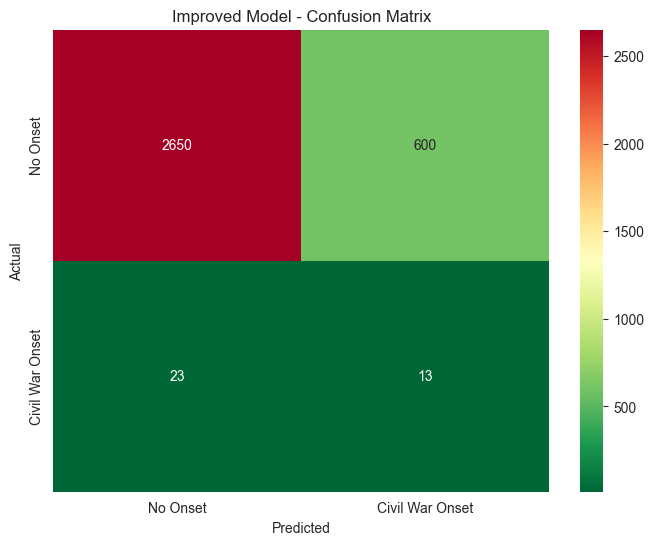

In [24]:
# ========================
# IMPROVED LOGISTIC REGRESSION MODEL
# ========================

print("Training improved Logistic Regression model...")

# Train model with balanced data
lr_model_improved = LogisticRegression(
    penalty='l2',
    C=0.1,  # Regularization
    class_weight=None,  # We already balanced with SMOTE
    max_iter=2000,
    random_state=42,
    solver='lbfgs'
)

lr_model_improved.fit(X_train_resampled, y_train_resampled)

print("✓ Improved model trained!")

# Make predictions
y_train_pred_imp = lr_model_improved.predict(X_train_enh_scaled)
y_test_pred_imp = lr_model_improved.predict(X_test_enh_scaled)

y_train_pred_proba_imp = lr_model_improved.predict_proba(X_train_enh_scaled)[:, 1]
y_test_pred_proba_imp = lr_model_improved.predict_proba(X_test_enh_scaled)[:, 1]

# Evaluate
print("\n" + "="*70)
print("IMPROVED MODEL PERFORMANCE")
print("="*70)

print("\nTRAINING SET:")
print(f"Accuracy: {accuracy_score(y_train_enh, y_train_pred_imp):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train_enh, y_train_pred_proba_imp):.4f}")
print(f"F1-Score: {f1_score(y_train_enh, y_train_pred_imp):.4f}")

print("\nTEST SET:")
print(f"Accuracy: {accuracy_score(y_test_enh, y_test_pred_imp):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_test_pred_proba_imp):.4f}")
print(f"F1-Score: {f1_score(y_test_enh, y_test_pred_imp):.4f}")

print("\n📈 COMPARISON WITH BASELINE:")
print(f"ROC-AUC Improvement: {roc_auc_score(y_test_enh, y_test_pred_proba_imp) - 0.7036:.4f}")
print(f"F1-Score Improvement: {f1_score(y_test_enh, y_test_pred_imp) - 0.0403:.4f}")

print("\nCLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test_enh, y_test_pred_imp, target_names=['No Onset', 'Civil War Onset']))

# Confusion Matrix
cm_imp = confusion_matrix(y_test_enh, y_test_pred_imp)
print("\nCONFUSION MATRIX (Test Set):")
print(cm_imp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_imp, annot=True, fmt='d', cmap='RdYlGn_r', 
            xticklabels=['No Onset', 'Civil War Onset'],
            yticklabels=['No Onset', 'Civil War Onset'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Improved Model - Confusion Matrix')
plt.show()

Analyzing feature importance...

TOP 20 MOST IMPORTANT FEATURES
           Feature  Coefficient  Abs_Coefficient
8            exrec     1.702386         1.702386
1            democ    -1.105567         1.105567
25      autoc_lag2     0.874621         0.874621
5           xrcomp    -0.816408         0.816408
26      autoc_lag3    -0.776730         0.776730
37     xropen_lag2    -0.753432         0.753432
28    durable_lag2    -0.752918         0.752918
36     xropen_lag1     0.704631         0.704631
34     xrcomp_lag2     0.686937         0.686937
21      democ_lag1    -0.671734         0.671734
43      exrec_lag2    -0.561666         0.561666
12  full_democracy     0.533061         0.533061
7          parcomp     0.493778         0.493778
22      democ_lag2     0.479214         0.479214
42      exrec_lag1     0.439020         0.439020
41    parcomp_lag3    -0.434543         0.434543
38     xropen_lag3     0.429612         0.429612
47    exconst_lag3    -0.415542         0.415542
35   

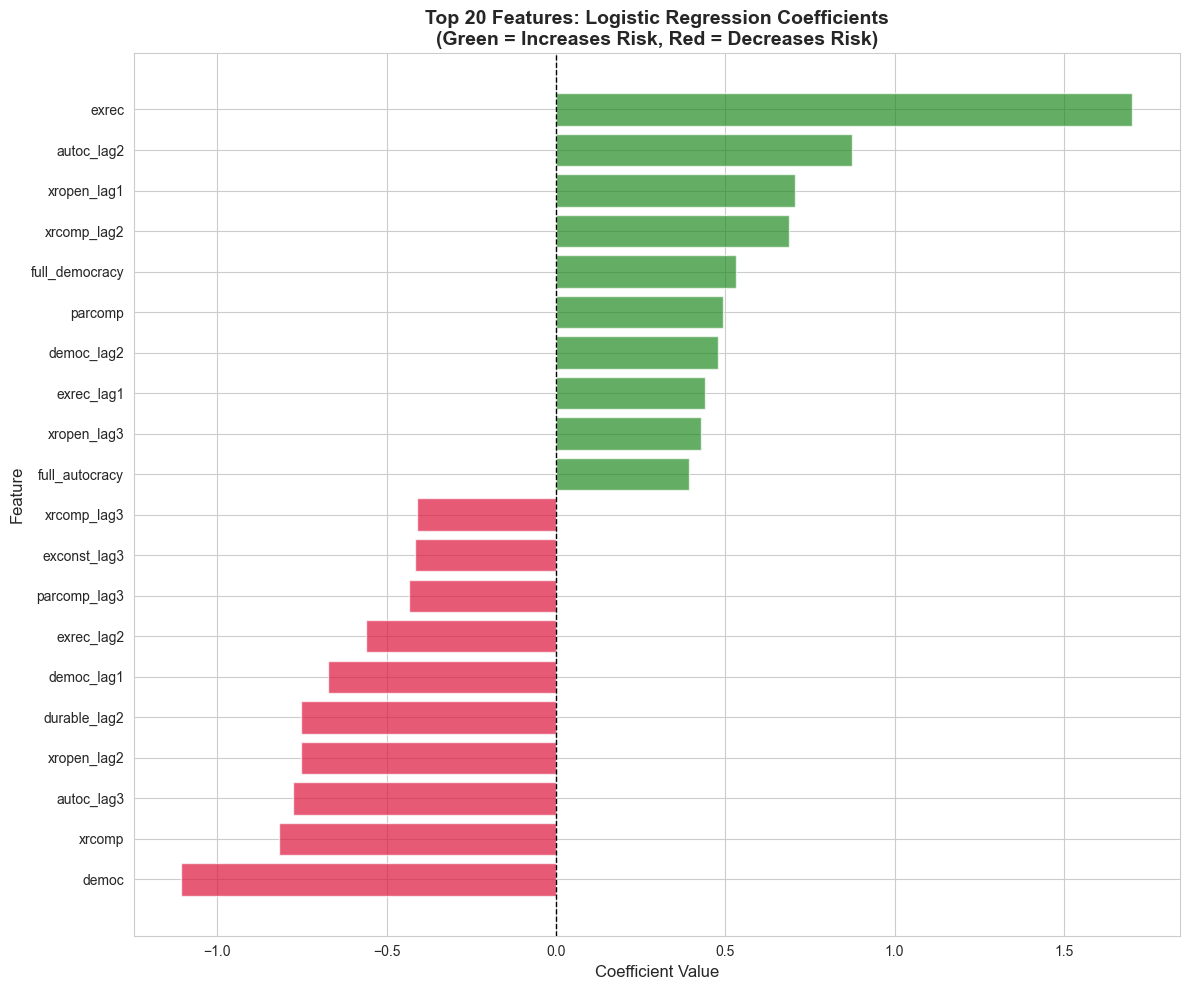

In [25]:
# ========================
# FEATURE IMPORTANCE
# ========================

print("Analyzing feature importance...")

feature_names_enh = X_enhanced.columns.tolist()

coefficients_enh = pd.DataFrame({
    'Feature': feature_names_enh,
    'Coefficient': lr_model_improved.coef_[0],
    'Abs_Coefficient': abs(lr_model_improved.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)
print(coefficients_enh.head(20))

# Visualize top features
plt.figure(figsize=(12, 10))
top_20_features = coefficients_enh.head(20).sort_values('Coefficient')
colors = ['crimson' if x < 0 else 'forestgreen' for x in top_20_features['Coefficient']]
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features: Logistic Regression Coefficients\n(Green = Increases Risk, Red = Decreases Risk)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

Training ensemble models for comparison...

1. Random Forest...
   Accuracy: 0.9799
   ROC-AUC: 0.6766
   F1-Score: 0.0571

2. Gradient Boosting...
   Accuracy: 0.9854
   ROC-AUC: 0.6433
   F1-Score: 0.0769

MODEL COMPARISON
                 Model  Accuracy   ROC-AUC  F1-Score
0          Baseline LR  0.713100  0.703600  0.040300
1  Improved LR (SMOTE)  0.810408  0.681120  0.040062
2        Random Forest  0.979915  0.676581  0.057143
3    Gradient Boosting  0.985393  0.643299  0.076923


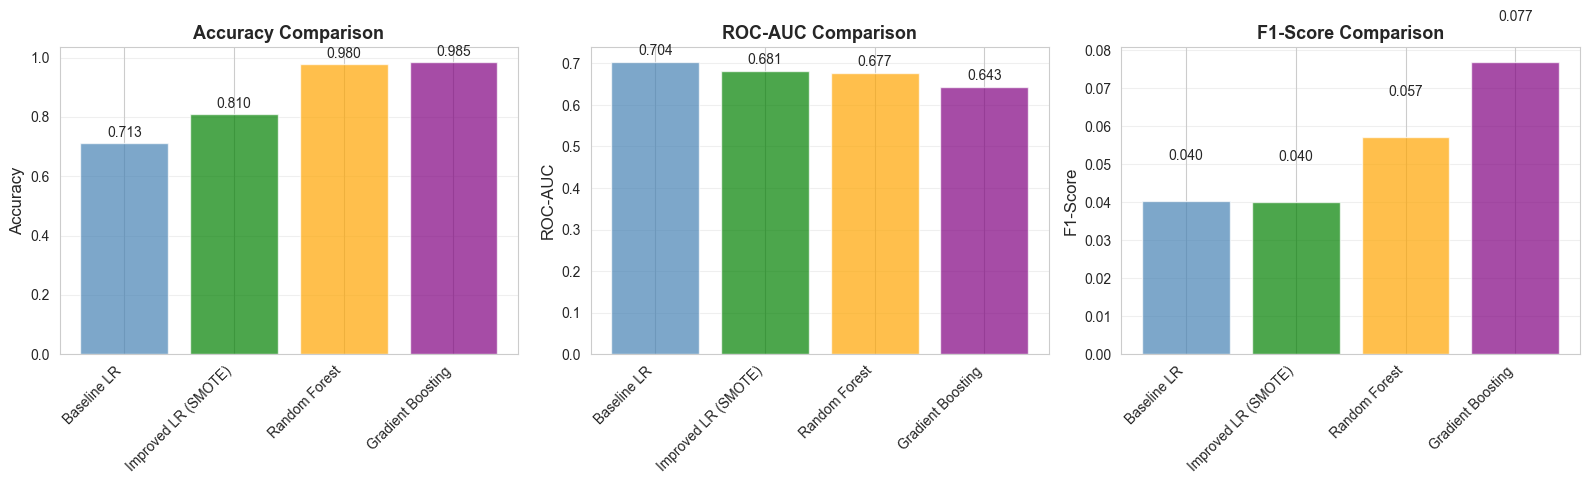

In [27]:
# ========================
# ENSEMBLE MODELS FOR COMPARISON
# ========================

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer

print("Training ensemble models for comparison...")

# Random Forest
print("\n1. Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_enh_scaled, y_train_enh)

y_test_pred_rf = rf_model.predict(X_test_enh_scaled)
y_test_pred_proba_rf = rf_model.predict_proba(X_test_enh_scaled)[:, 1]

print(f"   Accuracy: {accuracy_score(y_test_enh, y_test_pred_rf):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test_enh, y_test_pred_proba_rf):.4f}")
print(f"   F1-Score: {f1_score(y_test_enh, y_test_pred_rf):.4f}")

# Gradient Boosting
print("\n2. Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train_resampled, y_train_resampled)

y_test_pred_gb = gb_model.predict(X_test_enh_scaled)
y_test_pred_proba_gb = gb_model.predict_proba(X_test_enh_scaled)[:, 1]

print(f"   Accuracy: {accuracy_score(y_test_enh, y_test_pred_gb):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test_enh, y_test_pred_proba_gb):.4f}")
print(f"   F1-Score: {f1_score(y_test_enh, y_test_pred_gb):.4f}")

# Model Comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

models_comparison = pd.DataFrame({
    'Model': ['Baseline LR', 'Improved LR (SMOTE)', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        0.7131,
        accuracy_score(y_test_enh, y_test_pred_imp),
        accuracy_score(y_test_enh, y_test_pred_rf),
        accuracy_score(y_test_enh, y_test_pred_gb)
    ],
    'ROC-AUC': [
        0.7036,
        roc_auc_score(y_test_enh, y_test_pred_proba_imp),
        roc_auc_score(y_test_enh, y_test_pred_proba_rf),
        roc_auc_score(y_test_enh, y_test_pred_proba_gb)
    ],
    'F1-Score': [
        0.0403,
        f1_score(y_test_enh, y_test_pred_imp),
        f1_score(y_test_enh, y_test_pred_rf),
        f1_score(y_test_enh, y_test_pred_gb)
    ]
})

print(models_comparison)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, metric in enumerate(['Accuracy', 'ROC-AUC', 'F1-Score']):
    axes[idx].bar(models_comparison['Model'], models_comparison[metric], 
                  color=['steelblue', 'green', 'orange', 'purple'], alpha=0.7)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    axes[idx].set_xticklabels(models_comparison['Model'], rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(models_comparison[metric]):
        axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Finding optimal classification threshold...

Optimal Threshold: 0.8350
Max F1-Score: 0.1022

PERFORMANCE WITH OPTIMAL THRESHOLD
Accuracy: 0.9626
ROC-AUC: 0.6811
F1-Score: 0.1022
Precision: 0.0693
Recall: 0.1944

Classification Report (Optimal Threshold):
                 precision    recall  f1-score   support

       No Onset       0.99      0.97      0.98      3250
Civil War Onset       0.07      0.19      0.10        36

       accuracy                           0.96      3286
      macro avg       0.53      0.58      0.54      3286
   weighted avg       0.98      0.96      0.97      3286



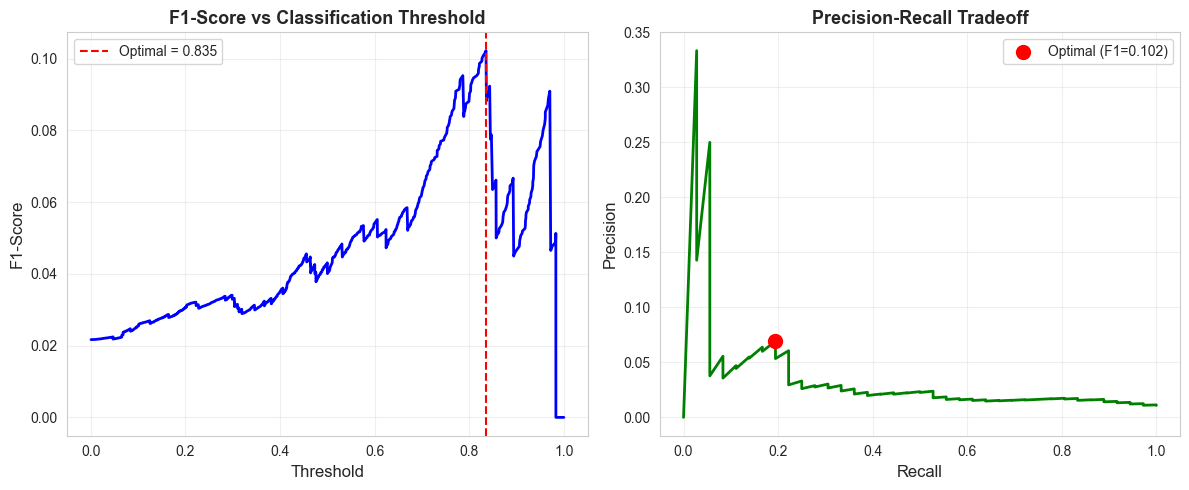

In [28]:
# ========================
# THRESHOLD OPTIMIZATION
# ========================

print("Finding optimal classification threshold...")

# Calculate precision-recall for different thresholds
precision, recall, thresholds_pr = precision_recall_curve(y_test_enh, y_test_pred_proba_imp)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Find optimal threshold (max F1)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"Max F1-Score: {f1_scores[optimal_idx]:.4f}")

# Apply optimal threshold
y_test_pred_optimal = (y_test_pred_proba_imp >= optimal_threshold).astype(int)

print("\n" + "="*70)
print("PERFORMANCE WITH OPTIMAL THRESHOLD")
print("="*70)
print(f"Accuracy: {accuracy_score(y_test_enh, y_test_pred_optimal):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_enh, y_test_pred_proba_imp):.4f}")
print(f"F1-Score: {f1_score(y_test_enh, y_test_pred_optimal):.4f}")
print(f"Precision: {precision[optimal_idx]:.4f}")
print(f"Recall: {recall[optimal_idx]:.4f}")

print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test_enh, y_test_pred_optimal, target_names=['No Onset', 'Civil War Onset']))

# Plot threshold vs F1
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds_pr, f1_scores[:-1], 'b-', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal = {optimal_threshold:.3f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('F1-Score vs Classification Threshold', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recall[:-1], precision[:-1], 'g-', linewidth=2)
plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', s=100, zorder=5,
            label=f'Optimal (F1={f1_scores[optimal_idx]:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Tradeoff', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()